# **On the impact of asynchronicity in stochastic gradient descent**

Optimization for Machine Learning course project.

Team members:
 - Nghia Nguyen Dai
 - Jean-Daniel Rouveyrol
 - Anthony Ducret


### **Abstract**
This study investigates the impact of the asynchronicity incorporated into stochastic gradient descent (SGD) on the optimization of large-scale models. Asynchronous SGD allows independent updates of model parameters based on gradient computed via each worker's fraction of the dataset. In contrast, synchronous SGD synchronizes model updates across all workers after each mini-batch to ensure consistent global updates. We conduct empirical evaluations and comparative analyses to examine the advantages, disadvantages, and trade-offs associated with both approaches. The study demonstrates that asynchronous SGD exhibits some regularization effects with a more pronounced result as the number of workers increases. However, it trade-offs in terms of slightly higher overall loss compared to synchronous SGD as well as the high sensitivity to the learning rate. The choice between the two methods depends on the specific requirements of the training scenario, considering factors such as training time, overall accuracy, and generalization. Further research is needed to explore convergence patterns and behaviors of different training variations, particularly with a higher number of workers.


### **Notebook description**

All the experiments for the main report could be reproduced using this notebook as one run from start to finish. However, due to the computation requirement of Async SGD, it is recommended to run this on a machine with more than 20GB of CPU memory and 15 GB of GPU memory. We perform the experiment using Colab Pro high-RAM environment. Otherwise, with a regular version of Colab, you could only run the 4-worker version.

### **Install and import**

In [ ]:
!pip install -q ray torch torchvision numpy pandas matplotlib seaborn scikit-learn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 88.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torch.nn.utils as nn_utils
import torch.utils.tensorboard as tb_utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ray
import random
import os
import gc
import json
import shutil

from collections import namedtuple, defaultdict
from itertools import repeat, chain
from typing import List, Optional, Dict
from tqdm.autonotebook import tqdm
from copy import deepcopy
from sklearn.metrics import accuracy_score, f1_score

### **Utilities**

In [ ]:
DATA_DIR = 'data'
TENSORBOARD_DIR = 'tensorboard'
SAVE_DIR = 'save'
SEED = 0

DEFAULT_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEFAULT_WRITER = tb_utils.SummaryWriter(log_dir=TENSORBOARD_DIR)

# Helper classes for later
ComponentInit = namedtuple('ComponentInit', ['cls', 'args'])
WorkerProgress = namedtuple('WorkerProgress', ['step_id', 'loss'])

In [ ]:
def get_rng(seed=SEED, kind='pt'):
    """
    Get a random generator, either in torch or in numpy. Default to torch
    """
    assert kind in ['pt', 'np']
    if kind == 'pt':
        return torch.Generator().manual_seed(seed)
    if kind == 'np':
        return np.random.default_rng(seed)

def ensure_reproducibility(seed=SEED):
    """
    Use deterministic procedure to run the notebook.
    However, there are still uncertainty in the asynchronousity of the workers.
    Therefore, complete reproducibility is not guaranteed.
    """
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(mode=True, warn_only=True)
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

ensure_reproducibility()

### **Model**

In [ ]:
"""
AlexNet for CIFAR10 Dataset, references from
https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb
"""
class AlexNet(nn.Module):
    def __init__(self, num_input_channels=3, num_labels=10, dropout=0.0):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(num_input_channels, 64, 3, 2, 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_labels),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

### **Datasets**

We provide `BaseDatasetWrapper` as a simple wrapper around torchvision's dataset. Inherit this class and replace the `datasets` property to init other variants.The train dataset and validation dataset could be accessed using `wrapper.train_dataset` and `wrapper.validation_dataset`

In [ ]:
"""
A simple wrapper around torchvision's dataset. Inherit this class and replace the
'datasets' property to init other variants.
"""
class BaseDatasetWrapper:
    def __init__(self, root: str = DATA_DIR, seed: int = SEED):
        self.root, self.seed = root, seed

        self.full_dataset = data_utils.ConcatDataset(self.datasets)
        self.train_dataset, self.validation_dataset = data_utils.random_split(
            self.full_dataset, lengths=[0.8, 0.2], generator=get_rng(self.seed)
        )

    @property
    def num_classes(self):
        raise NotImplementedError

    @property
    def transform(self):
        return None

    @property
    def target_transform(self):
        return None

    @property
    def datasets(self):
        return NotImplementedError


class CIFAR10Wrapper(BaseDatasetWrapper):
    @property
    def num_classes(self):
        return 10

    @property
    def transform(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[x /255 for x in [125.3, 123.0, 113.9]],
                std=[x / 255 for x in [63.0, 62.1, 66.7]]
            ),
        ])

    @property
    def datasets(self):
        return [
            datasets.CIFAR10(
                root=self.root, train=train, download=True,
                transform=self.transform, target_transform=self.target_transform
            )
            for train in [True, False]
        ]

### **Trainers**

`BaseTrainer` is the general base class for both the synchronous and asynchronous versions. After initialization, the trainer could be run using the `train` method. Both trainers share many of the common methods such as writing logs or evaluation. The logs are saved as a JSON file at the end of the training.

##### **Base class**

Each trainer take three main `ComponentInit`: model, criterion, and optimizer. Replace the `ComponentInit` to create a new model, criterion, or optimizer.

In [ ]:
class BaseTrainer:
    model_init = ComponentInit(cls=AlexNet, args={'num_labels': 10, 'num_input_channels': 3})
    criterion_init = ComponentInit(cls=nn.CrossEntropyLoss, args={})
    optimizer_init = ComponentInit(cls=optim.SGD, args={'lr': 5e-2, 'momentum': 0})
    eval_funcs = {
        'accuracy': lambda outputs, labels: accuracy_score(labels, outputs),
        'f1': lambda outputs, labels: f1_score(labels, outputs, average='macro')
    }

    tb_writer = DEFAULT_WRITER
    save_dir = SAVE_DIR

    def __init__(
        self,
        train_dataset: data_utils.Dataset,
        validation_dataset: data_utils.Dataset,
        batch_size: int = 32,
        num_epochs: int = 4,
        eval_per_steps: int = 200,
        seed: int = SEED,
        device=DEFAULT_DEVICE,
        save_dir: str = SAVE_DIR,
    ):
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.eval_per_steps = eval_per_steps
        self.seed = seed
        self.device = device
        self.save_dir = save_dir

        self.model = self.model_init.cls(**self.model_init.args)
        self.model.to(self.device)
        self.train_loader, self.validation_loader = (
            data_utils.DataLoader(dataset, self.batch_size, shuffle=False)
            for dataset in (self.train_dataset, self.validation_dataset)
        )

    def train(self):
        raise NotImplementedError

    def eval(self, loader: data_utils.DataLoader):
        """
        Run evaluation including loss and additional specified metrics
        """
        criterion = self.criterion_init.cls(**self.criterion_init.args)
        self.model.eval()
        self.model.to(self.device)
        losses = []

        all_outputs = []
        all_labels = []

        with torch.no_grad():
            loader_with_pbar = tqdm(loader, desc='Eval')
            for inputs, labels in loader_with_pbar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                losses.append(loss.item())

                all_outputs.append(outputs.argmax(dim=1).detach().cpu().numpy())
                all_labels.append(labels.detach().cpu().numpy())

            loader_with_pbar.close()

        eval_func_results = {
            key: func(np.hstack(all_outputs), np.hstack(all_labels))
            for key, func in self.eval_funcs.items()
        }

        return np.mean(losses), eval_func_results

    def write_log(
        self,
        step_id: int,
        train_loss: float,
        validation_loss: float,
        eval_func_results: Dict[str, float]
    ):
        """
        Write log to Tensorboard for visualization
        """
        result = {
            'train': train_loss,
            'validation': validation_loss
        }

        self.tb_writer.add_scalars(f'{self.name}', result, step_id)
        self.tb_writer.add_scalars(f'{self.name}_metric', eval_func_results, step_id)
        tqdm.write(str({**result, **eval_func_results}))
        self.tb_writer.flush()

    def save_log(
        self,
        train_losses: List[float],
        validation_losses: List[float],
        all_eval_func_results: List[Dict[str, float]]
    ):
        """
        Save all training logs for later plotting
        """
        save_dir = os.path.join(self.save_dir, self.name)
        os.makedirs(save_dir, exist_ok=True)

        log = defaultdict(list)
        for eval_func_results in all_eval_func_results:
            for key, val in eval_func_results.items():
                log[key].append(val)
        log['train'] = train_losses
        log['validation'] = validation_losses
        with open(os.path.join(save_dir, 'log.json'), 'w') as file:
            json.dump(log, file)

    @property
    def name(self):
        raise NotImplementedError

##### **Sync SGD**

In [ ]:
class SyncTrainer(BaseTrainer):
    def train(self):
        criterion = self.criterion_init.cls(**self.criterion_init.args)
        optimizer = self.optimizer_init.cls(
            self.model.parameters(), **self.optimizer_init.args
        )

        train_losses = []
        validation_losses = []
        all_eval_func_results = []

        for epoch_id in range(self.num_epochs):
            desc = f'Epoch [{epoch_id + 1:#3d}|{self.num_epochs}]'
            train_loader_with_pbar = tqdm(self.train_loader, desc=desc)
            for batch_id, (feature, label) in enumerate(train_loader_with_pbar):
                self.model.train()
                feature, label = feature.to(self.device), label.to(self.device)

                output = self.model(feature)
                loss = criterion(output, label)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                train_loader_with_pbar.set_description(
                    f'{desc} - [{loss.item():#.2f}]'
                )

                step_id = epoch_id * len(self.train_loader) + batch_id
                if (step_id + 1) % self.eval_per_steps == 0:
                    tqdm.write(f'Eval for step {step_id + 1}')
                    train_loss, _ = self.eval(self.train_loader)
                    train_losses.append(train_loss)
                    validation_loss, eval_func_results = self.eval(self.validation_loader)
                    validation_losses.append(validation_loss)
                    all_eval_func_results.append(eval_func_results)
                    self.write_log(step_id, train_loss, validation_loss, eval_func_results)

        self.save_log(train_losses, validation_losses, all_eval_func_results)
        return train_losses, validation_losses, all_eval_func_results

    @property
    def name(self):
        return 'sync'

##### **Async SGD**

We use a Python lib called `ray` to handle worker creation and communication.

In [ ]:
"""
The worker handles the training and communicate with the checkpointer
to update the base model. The update is performed after the gradient computation
of each minibatch. The worker then get the new state from the base model to
continue new gradient calculation.
"""
@ray.remote
class Worker:
    def __init__(
        self,
        checkpointer_remote,
        id: int,
        model_init: ComponentInit,
        criterion_init: ComponentInit,
        dataset: data_utils.Dataset,
        batch_size: int,
        num_epochs: int,
        seed: int,
        device=DEFAULT_DEVICE,
    ):
        self.checkpointer_remote = checkpointer_remote
        self.id = id
        self.model_init = model_init
        self.criterion_init = criterion_init
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.seed = seed
        self.device = device

        self.loader = data_utils.DataLoader(
            self.dataset, self.batch_size,
            shuffle=True, generator=get_rng(self.seed)
        )

    def run(self):
        model = self.model_init.cls(**self.model_init.args)
        model.to(self.device)

        criterion = self.criterion_init.cls(**self.criterion_init.args)
        model.load_state_dict(
            ray.get(self.checkpointer_remote.get_model_state.remote())
        )

        model.train()
        for epoch_id in range(self.num_epochs):
            for batch_id, (inputs, labels) in enumerate(self.loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()

                grads = [param.grad for param in model.parameters()]
                step_id = epoch_id * len(self.loader) + batch_id
                new_state = ray.get(
                    self.checkpointer_remote.update_params.remote(
                        grads, self.id, step_id, loss.item()
                    )
                )
                model.zero_grad()
                model.load_state_dict(new_state)

"""
The checkpointer could be considered as a parameter server. It store the main model
and perform update whenever new gradient is sent to it. It also save the old model
for later evaluation.
"""
@ray.remote
class Checkpointer:
    tmp_dir = 'tmp'
    def __init__(
        self,
        model: nn.Module,
        optimizer_init: ComponentInit,
        save_per_steps: int,
        save_dir='tmp',
        device=DEFAULT_DEVICE,
    ):
        self.model = model
        self.device = device
        self.model.to(self.device)
        self.optimizer = optimizer_init.cls(
            model.parameters(),
            **optimizer_init.args
        )
        self.save_per_steps = save_per_steps
        self.worker_id_to_progress = defaultdict(list)
        self.step_id_to_state = {}

        os.makedirs(self.tmp_dir, exist_ok=True)

    def get_model_state(self, step_id: Optional[int] = None):
        if step_id:
            return torch.load(self.step_id_to_state[step_id])
        return deepcopy(self.model.state_dict())

    def update_params(
        self,
        grads: List[torch.Tensor],
        worker_id: int,
        step_id: int,
        loss: float
    ):
        for (param, grad) in zip (self.model.parameters(), grads):
            param.grad = grad
        nn_utils.clip_grad_norm_(self.model.parameters(), 100)
        self.optimizer.step()
        self.optimizer.zero_grad()

        self.worker_id_to_progress[worker_id].append(
            WorkerProgress(step_id, loss)
        )

        model_state = deepcopy(self.model.state_dict())
        num_steps = sum(
            len(progress) for progress in self.worker_id_to_progress.values()
        )
        if num_steps % self.save_per_steps == 0:
            path = f'{self.tmp_dir}/{num_steps}.pt'
            torch.save(model_state, path)
            self.step_id_to_state[num_steps] = path
        return model_state

    def get_progress(self):
        return self.worker_id_to_progress

The training logic of `AsyncTrainer` is a bit different. For `SyncTrainer`, evaluation is performed every `k` steps. For `AsyncTrainer`, the training is performed from start to end and after every $k$ step, the old model is saved. After the training is completed, the evaluation is performed based on the saved model.

In [ ]:
class AsyncTrainer(BaseTrainer):
    def __init__(
        self,
        train_dataset: data_utils.Dataset,
        validation_dataset: data_utils.Dataset,
        batch_size: int = 32,
        num_epochs: int = 4,
        eval_per_steps: int = 200,
        seed: int = SEED,
        device=DEFAULT_DEVICE,
        save_dir: str = SAVE_DIR,
        num_workers: int = 4
    ):
        super().__init__(
            train_dataset=train_dataset,
            validation_dataset=validation_dataset,
            batch_size=batch_size,
            num_epochs=num_epochs,
            eval_per_steps=eval_per_steps,
            seed=seed,
            device=device,
            save_dir=save_dir
        )

        self.num_workers = num_workers

        # Define the resource that each worker gets
        self.remote_options = {
            'num_gpus': 1 / (self.num_workers + 1),
            'num_cpus': 2 / (self.num_workers + 1)
        }
        self.checkpointer_remote = Checkpointer.options(**self.remote_options).remote(
            self.model, self.optimizer_init, self.eval_per_steps, self.device
        )

        # Split the dataset into many subsets for the workers
        self.train_subsets = data_utils.random_split(
            self.train_dataset,
            [1 / self.num_workers for _ in range(self.num_workers)],
            generator=get_rng(self.seed)
        )
        # Each worker have a progress bar to show it training progress
        self.worker_id_to_pbar = {
            worker_id: tqdm(
                total=int(np.ceil(len(dataset) / self.batch_size)) * self.num_epochs,
                desc=f'Worker [{worker_id}]'
            )
            for worker_id, dataset in enumerate(self.train_subsets)
        }
        # The total steps that all workers perform, this is used to determine
        # when the training ends
        self.num_total_steps = sum(
            pbar.total for pbar in self.worker_id_to_pbar.values()
        )

    def _init_worker_remotes(self):
        """
        Create all the workers with valid parameters and dataset.
        """
        seeds = get_rng(self.seed, 'np').integers(100, size=(self.num_workers))
        worker_remotes = [
            Worker.options(**self.remote_options).remote(
                self.checkpointer_remote, id=worker_id,
                model_init=self.model_init, criterion_init=self.criterion_init,
                dataset=dataset, batch_size=self.batch_size,
                num_epochs=self.num_epochs, seed=int(seed), device=self.device
            )
            for (worker_id, dataset), seed in zip(
                enumerate(self.train_subsets), seeds
            )
        ]
        ray.get(
            [worker_remote.__ray_ready__.remote() for worker_remote in worker_remotes]
        )
        return worker_remotes

    def _update_worker_progress(self):
        """
        If the total number of steps performed is not equal to
        `self.num_total_steps`, we update the progress bar.
        """
        worker_id_to_progress = ray.get(self.checkpointer_remote.get_progress.remote())
        num_steps = sum(len(progress) for progress in worker_id_to_progress.values())

        if num_steps >= self.num_total_steps:
            num_steps = self.num_total_steps

        for worker_id, progress in worker_id_to_progress.items():
            if not progress:
                continue
            step_id, loss = progress[-1]
            pbar = self.worker_id_to_pbar[worker_id]
            pbar.update(step_id + 1 - pbar.n)
            pbar.set_description(f'Worker [{worker_id}] - Loss [{loss:#.2f}]')

        return num_steps

    def _fetch_model(self, step_id: Optional[int] = None):
        """Fetch newest model from the checkpointer"""
        self.model.load_state_dict(
            ray.get(self.checkpointer_remote.get_model_state.remote(step_id))
        )

    def train(self):
        worker_remotes = self._init_worker_remotes()
        run_remotes = [
            worker_remote.run.remote()
            for worker_remote in worker_remotes
        ]

        train_losses, validation_losses, all_eval_func_results = [], [], []

        num_steps = self._update_worker_progress()
        while num_steps != self.num_total_steps:
            num_steps = self._update_worker_progress()

        for step_id in range(
            self.eval_per_steps,
            self.num_total_steps + 1,
            self.eval_per_steps
        ):
            tqdm.write(f'Eval for step {step_id}')
            self._fetch_model(step_id)
            train_loss, _ = self.eval(self.train_loader)
            validation_loss, eval_func_results = self.eval(self.validation_loader)

            train_losses.append(train_loss)
            validation_losses.append(validation_loss)
            all_eval_func_results.append(eval_func_results)
            self.write_log(step_id, train_loss, validation_loss, eval_func_results)

        self._fetch_model()
        self.save_log(train_losses, validation_losses, all_eval_func_results)

        shutil.rmtree(Checkpointer.tmp_dir)
        return train_losses, validation_losses, all_eval_func_results

    @property
    def name(self):
        return f'async-{self.num_workers}'

### **Experiments**

This section contains all the variants we peformed

In [ ]:
"""
Shared training arguments for all variants
"""

cifar10_wrapper = CIFAR10Wrapper()

default_trainer_args = dict(
    train_dataset=cifar10_wrapper.train_dataset,
    validation_dataset=cifar10_wrapper.validation_dataset,
    batch_size=32,
    num_epochs=12,
    eval_per_steps=100
)

100%|██████████| 170498071/170498071 [00:11<00:00, 15169807.42it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


##### **Sync SGD**

In [ ]:
sync_trainer_args = {
    **default_trainer_args,
    'save_dir': f'{SAVE_DIR}/dropout00'
}

%time SyncTrainer(**sync_trainer_args).train()
gc.collect()

##### **Sync SGD with droppout**

In [ ]:
class Dropout25SyncTrainer(SyncTrainer):
    model_init = ComponentInit(cls=AlexNet, args={'num_labels': 10, 'num_input_channels': 3, 'dropout': 0.25})

dropout25_sync_trainer_args = {
    **default_trainer_args,
    'save_dir': f'{SAVE_DIR}/dropout25'
}

%time Dropout25SyncTrainer(**dropout25_sync_trainer_args).train()
gc.collect()

In [ ]:
class Dropout50SyncTrainer(SyncTrainer):
    model_init = ComponentInit(cls=AlexNet, args={'num_labels': 10, 'num_input_channels': 3, 'dropout': 0.5})

dropout50_sync_trainer_args = {
    **default_trainer_args,
    'save_dir': f'{SAVE_DIR}/dropout50'
}

%time Dropout50SyncTrainer(**dropout50_sync_trainer_args).train()
gc.collect()

##### **Async SGD 4 workers**

In [ ]:
ray.shutdown()
ray.init()
async4_trainer_args = {
    **default_trainer_args,
    'num_workers': 4,
    'save_dir': f'{SAVE_DIR}/dropout00'
}

%time AsyncTrainer(**async4_trainer_args).train()
gc.collect()

##### **Async SGD 8 workers**

In [ ]:
ray.shutdown()
ray.init()
async8_trainer_args = {
    **default_trainer_args,
    'num_workers': 8,
    'save_dir': f'{SAVE_DIR}/dropout00'
}

%time AsyncTrainer(**async8_trainer_args).train()
gc.collect()

##### **Async SGD 12 workers**

In [ ]:
ray.shutdown()
ray.init()
async12_trainer_args = {
    **default_trainer_args,
    'num_workers': 12,
    'save_dir': f'{SAVE_DIR}/dropout00'
}

%time AsyncTrainer(**async12_trainer_args).train()
gc.collect()

### **Plot**

From the training results after completing all the previous sections, we could create all the training plot here.

In [3]:
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt

In [8]:
"""
Load all the saved logs
"""

with open(f'{SAVE_DIR}/dropout00/sync/log.json') as file:
    sync_log = json.load(file)
with open(f'{SAVE_DIR}/dropout25/sync/log.json') as file:
    sync25_log = json.load(file)
with open(f'{SAVE_DIR}/dropout50/sync/log.json') as file:
    sync50_log = json.load(file)
with open(f'{SAVE_DIR}/dropout00/async-4/log.json') as file:
    async4_log = json.load(file)
with open(f'{SAVE_DIR}/dropout00/async-8/log.json') as file:
    async8_log = json.load(file)
with open(f'{SAVE_DIR}/dropout00/async-12/log.json') as file:
    async12_log = json.load(file)

##### **Training loss and validation loss**

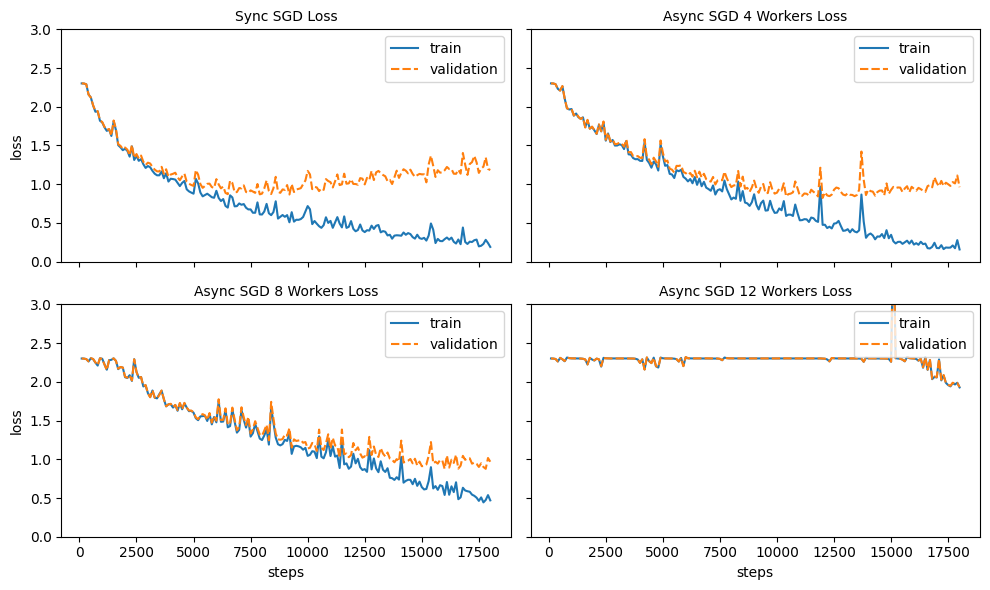

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

SEQ_LENGTH = 180

sync_df = pd.DataFrame(
    data={
        'train': sync_log['train'][:SEQ_LENGTH],
        'validation': sync_log['validation'][:SEQ_LENGTH],
        'steps': list(range(100, 20000, 100))[:SEQ_LENGTH]
    }
).set_index('steps')

async4_df = pd.DataFrame(
    data={
        'train': async4_log['train'][:SEQ_LENGTH],
        'validation': async4_log['validation'][:SEQ_LENGTH],
        'steps': list(range(100, 20000, 100))[:SEQ_LENGTH]
    }
).set_index('steps')

async8_df = pd.DataFrame(
    data={
        'train': async8_log['train'][:SEQ_LENGTH],
        'validation': async8_log['validation'][:SEQ_LENGTH],
        'steps': list(range(100, 20000, 100))[:SEQ_LENGTH]
    }
).set_index('steps')

async12_df = pd.DataFrame(
    data={
        'train': async12_log['train'][:SEQ_LENGTH],
        'validation': async12_log['validation'][:SEQ_LENGTH],
        'steps': list(range(100, 20000, 100))[:SEQ_LENGTH]
    }
).set_index('steps')

for i, (df, name) in enumerate(
    [
        (sync_df, 'Sync SGD Loss'),
        (async4_df, 'Async SGD 4 Workers Loss'),
        (async8_df, 'Async SGD 8 Workers Loss'),
        (async12_df, 'Async SGD 12 Workers Loss'),
    ],
    start=1
):
    plt.subplot(2, 2, i)
    sns.lineplot(df)
    plt.legend(loc='upper right')
    plt.title(name, fontsize='medium')
    plt.ylabel('loss')

plt.ylim(0,3)
plt.tight_layout()
plt.show()

##### **Validation loss by step count and step group**

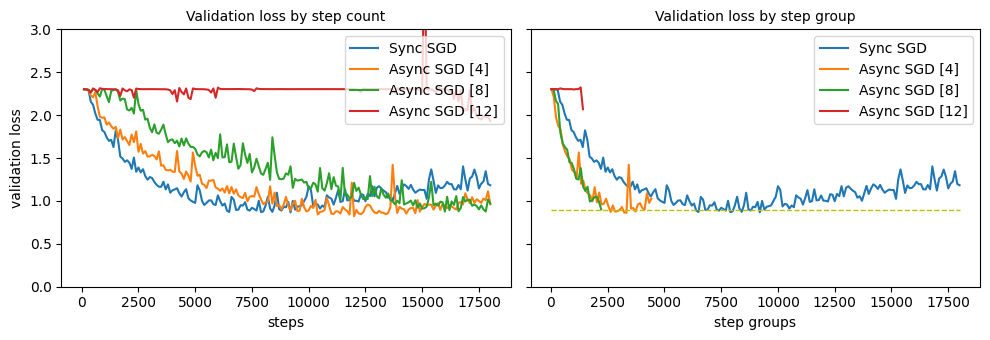

In [11]:
plt.subplots(1, 2, figsize=(10, 3.5), sharex=True, sharey=True)

plt.subplot(1, 2, 1)
for df, name in [
    (sync_df, 'Sync SGD'),
    (async4_df, 'Async SGD [4]'),
    (async8_df, 'Async SGD [8]'),
    (async12_df, 'Async SGD [12]')
]:
    sns.lineplot(df, x='steps', y='validation', label=name)

plt.ylabel('validation loss')
plt.title('Validation loss by step count', fontsize='medium')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)

async4_df_short = async4_df.copy().iloc[0:SEQ_LENGTH:4].reset_index()
async4_df_short['steps'] = async4_df_short['steps'].apply(lambda x: int(x / 4))
async4_df_short.set_index('steps', inplace=True)

async8_df_short = async8_df.copy().iloc[0:SEQ_LENGTH:8].reset_index()
async8_df_short['steps'] = async8_df_short['steps'].apply(lambda x: int(x / 8))
async8_df_short.set_index('steps', inplace=True)

async12_df_short = async12_df.copy().iloc[0:SEQ_LENGTH:12].reset_index()
async12_df_short['steps'] = async12_df_short['steps'].apply(lambda x: int(x / 12))
async12_df_short.set_index('steps', inplace=True)


for df, name in [
    (sync_df, 'Sync SGD'),
    (async4_df_short, 'Async SGD [4]'),
    (async8_df_short, 'Async SGD [8]'),
    (async12_df_short, 'Async SGD [12]')
]:
    sns.lineplot(df, x='steps', y='validation', label=name)

plt.ylabel('validation loss')
plt.ylim(0, 3)
plt.hlines(0.9, 0, SEQ_LENGTH * 100, colors='y', linestyles='--', linewidth=1)
plt.title('Validation loss by step group', fontsize='medium')
plt.xlabel('step groups')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

##### **Regularization effect**

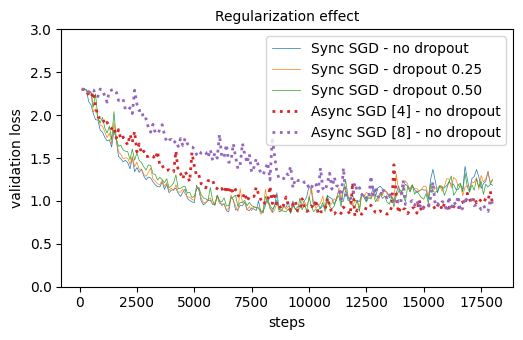

In [12]:
plt.figure(figsize=(10, 3.5))

sync25_df = pd.DataFrame(
    data={
        'train': sync25_log['train'][:SEQ_LENGTH],
        'validation': sync25_log['validation'][:SEQ_LENGTH],
        'steps': list(range(100, 20000, 100))[:SEQ_LENGTH]
    }
).set_index('steps')

sync50_df = pd.DataFrame(
    data={
        'train': sync50_log['train'][:SEQ_LENGTH],
        'validation': sync50_log['validation'][:SEQ_LENGTH],
        'steps': list(range(100, 20000, 100))[:SEQ_LENGTH]
    }
).set_index('steps')

plt.subplot(1, 2, 1)
for df, name, linestyle, linewidth in [
    (sync_df, 'Sync SGD - no dropout', '-', 0.5),
    (sync25_df, 'Sync SGD - dropout 0.25', '-', 0.5),
    (sync50_df, 'Sync SGD - dropout 0.50', '-', 0.5),
    (async4_df, 'Async SGD [4] - no dropout', ':', 2),
    (async8_df, 'Async SGD [8] - no dropout', ':', 2),
]:
    sns.lineplot(df, x='steps', y='validation', label=name, linestyle=linestyle, linewidth=linewidth)

plt.ylabel('validation loss')
plt.title('Regularization effect', fontsize='medium')
plt.legend(loc='upper right')
plt.ylim(0, 3)
plt.tight_layout()
plt.show()

##### **Comparision between Dropout and ASGD**

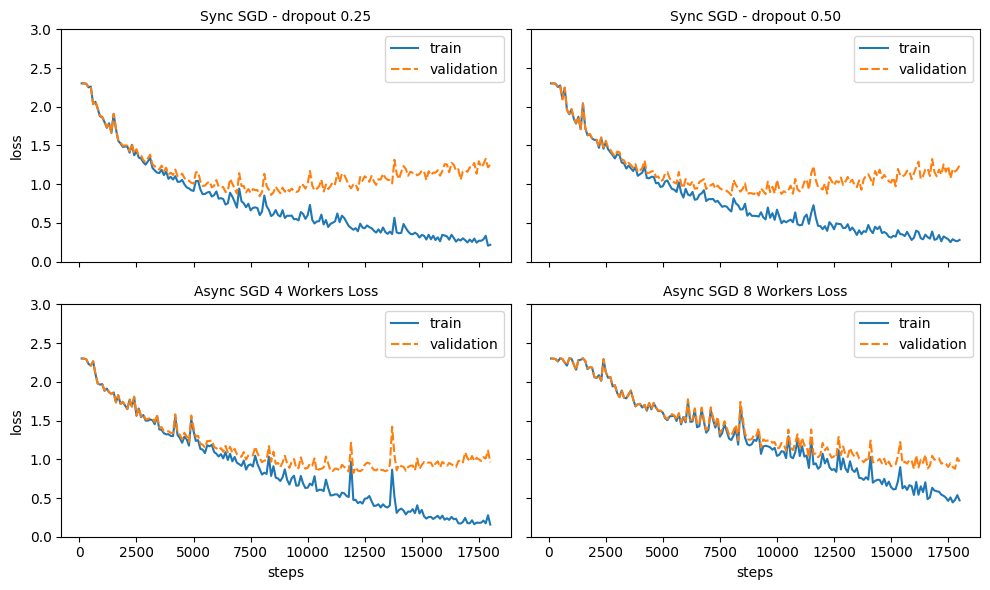

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

for i, (df, name) in enumerate(
    [
        (sync25_df, 'Sync SGD - dropout 0.25'),
        (sync50_df, 'Sync SGD - dropout 0.50'),
        (async4_df, 'Async SGD 4 Workers Loss'),
        (async8_df, 'Async SGD 8 Workers Loss'),
    ],
    start=1
):
    plt.subplot(2, 2, i)
    sns.lineplot(df)
    plt.legend(loc='upper right')
    plt.title(name, fontsize='medium')
    plt.ylabel('loss')

plt.ylim(0,3)
plt.tight_layout()
plt.show()

##### **Accuracy and F1**

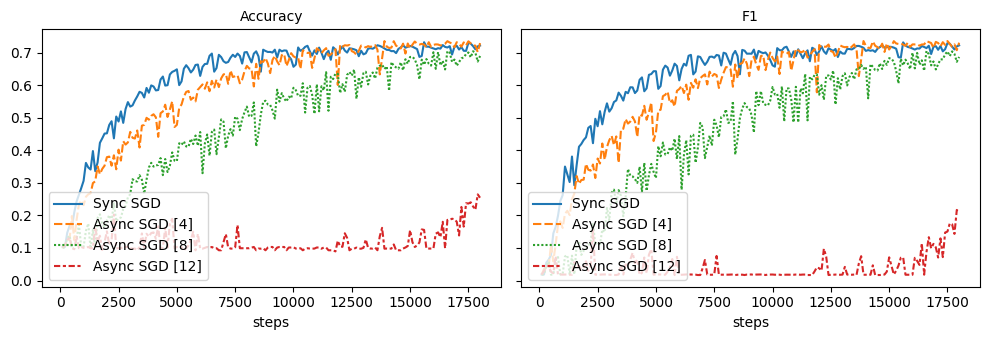

In [ ]:
plt.subplots(1, 2, figsize=(10, 3.5), sharex=True, sharey=True)

SEQ_LENGTH = 180

acc_df = pd.DataFrame(
    data={
        'Sync SGD': sync_log['accuracy'][:SEQ_LENGTH],
        'Async SGD [4]': async4_log['accuracy'][:SEQ_LENGTH],
        'Async SGD [8]': async8_log['accuracy'][:SEQ_LENGTH],
        'Async SGD [12]': async12_log['accuracy'][:SEQ_LENGTH],
        'steps': list(range(100, 20000, 100))[:SEQ_LENGTH]
    }
).set_index('steps')

f1_df = pd.DataFrame(
    data={
        'Sync SGD': sync_log['f1'][:SEQ_LENGTH],
        'Async SGD [4]': async4_log['f1'][:SEQ_LENGTH],
        'Async SGD [8]': async8_log['f1'][:SEQ_LENGTH],
        'Async SGD [12]': async12_log['f1'][:SEQ_LENGTH],
        'steps': list(range(100, 20000, 100))[:SEQ_LENGTH]
    }
).set_index('steps')

for i, (df, name) in enumerate(
    [(acc_df, 'Accuracy'), (f1_df, 'F1')],
    start=1
):
    plt.subplot(1, 2, i)
    sns.lineplot(df)
    plt.legend(loc='lower left')
    plt.title(name, fontsize='medium')
plt.tight_layout()
plt.show()